In [1]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is enabled!")
    except RuntimeError as e:
        print(e)

2025-06-01 10:55:46.982299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748775347.171518      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748775347.228822      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is enabled!


## Sentiment Analysis with LSTM, BERT, and BART

In this project, we employed different Neural Network and Transformer architectures, specifically LSTM, BERT, and BART, for Sentiment Analysis task on the Sentiment140 Tweets dataset

#### Importing Libraries

In [34]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, InputLayer, Bidirectional
from tensorflow.keras import models, layers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import torch
from transformers import BartForSequenceClassification, BartTokenizer, BertForSequenceClassification, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

TOP_WORDS = 8000
MAX_WORDS = 128
bert_checkpoint = "distilbert/distilbert-base-uncased"
bart_checkpoint = "sshleifer/distilbart-cnn-12-6"
dataset_path = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'

### Loading Data

In [3]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()


def load_data():
    df = pd.read_csv(dataset_path, encoding='latin-1', header=None)
    df = df[[0, 5]]
    df.columns = ['sentiment', 'text']

    label_map = {0: 0, 4: 1}
    df['sentiment'] = df['sentiment'].map(label_map)
    df['cleaned_text'] = df['text'].apply(clean_text)

    return df

### LSTM

#### Data Loading and Pre-processing

In [4]:
def pre_processing():
    df = load_data()

    tokenizer = Tokenizer(num_words=TOP_WORDS)
    tokenizer.fit_on_texts(df['cleaned_text'])
    sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
    padded_sequences = sequence.pad_sequences(sequences, maxlen=MAX_WORDS)

    labels = df['sentiment'].values

    X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

    return (X_train, y_train, X_val, X_test, y_val, y_test)

In [5]:
X_train, y_train, X_val, X_test, y_val, y_test = pre_processing()

#### Defining the Model

In [12]:
lstm_model = Sequential([
    InputLayer(shape=(500,)),
    Embedding(TOP_WORDS, 100),
    Bidirectional(LSTM(512, return_sequences=True, activation="tanh")),
    Dropout(0.5),
    Bidirectional(LSTM(256, activation="tanh")),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(1, activation='sigmoid'),
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 500, 100)            │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 500, 1024)           │       2,510,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 500, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,967,233 (22.76 MB)

 Trainable params: 5,967,233 (22.76 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the Model

In [14]:
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=256,
    verbose=1,
)

Epoch 1/4
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1303s 259ms/step - accuracy: 0.7790 - loss: 0.4618 - val_accuracy: 0.8146 - val_loss: 0.4039
Epoch 2/4
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1297s 259ms/step - accuracy: 0.8210 - loss: 0.3945 - val_accuracy: 0.8219 - val_loss: 0.3923
Epoch 3/4
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1297s 259ms/step - accuracy: 0.8324 - loss: 0.3731 - val_accuracy: 0.8244 - val_loss: 0.3863
Epoch 4/4
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1297s 259ms/step - accuracy: 0.8409 - loss: 0.3570 - val_accuracy: 0.8262 - val_loss: 0.3857


#### Validation vs Training Graph

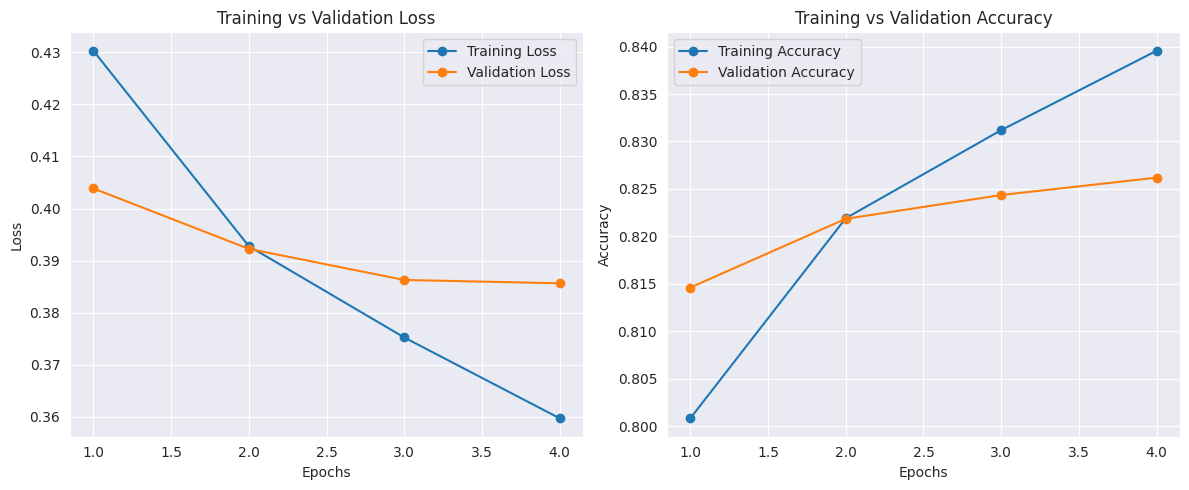

In [15]:
history_data = lstm_history.history
epochs = range(1, len(history_data['loss']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_data['loss'], label='Training Loss', marker='o')
plt.plot(epochs, history_data['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history_data['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history_data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Model

In [44]:
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {(accuracy * 100):.4f}%')

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 130s 26ms/step - accuracy: 0.8260 - loss: 0.3878
Test loss: 0.38588255643844604
Test accuracy: 82.7062%


In [46]:
y_pred_probs = lstm_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

try:
    roc_auc = roc_auc_score(y_test, y_pred)
except ValueError:
    roc_auc = "Not applicable (non-binary classification)"

print("\n--- Test Evaluation Metrics ---")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC-AUC: {roc_auc}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 124s 25ms/step

--- Test Evaluation Metrics ---
Precision (weighted): 0.8271
Recall (weighted): 0.8271
F1 Score (weighted): 0.8271
ROC-AUC: 0.827055285966515

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     80071
           1       0.83      0.82      0.83     79929

    accuracy                           0.83    160000
   macro avg       0.83      0.83      0.83    160000
weighted avg       0.83      0.83      0.83    160000



### BERT

#### Data Pre-Processing

In [17]:
tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint)

def tokenize_function(example):
    return tokenizer(
        example['cleaned_text'],
        add_special_tokens=True,
        max_length=MAX_WORDS,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )


def bert_pre_processing():
    BATCH_SIZE = 64

    df = load_data()
    df = df.sample(n=1_000_000).reset_index(drop=True)

    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'])

    train_dataset = Dataset.from_pandas(train_df[["cleaned_text", "sentiment"]])
    val_dataset = Dataset.from_pandas(val_df[["cleaned_text", "sentiment"]])
    test_dataset = Dataset.from_pandas(test_df[["cleaned_text", "sentiment"]])

    dataset = DatasetDict({
        "train": train_dataset,
        "test": test_dataset,
        "validation": val_dataset
    })

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")
    tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE)

    return (train_dataloader, val_dataloader, test_dataloader)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
train_dataset, val_dataset, test_dataset = bert_pre_processing()

Map:   0%|          | 0/700000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

#### Defining the Model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_checkpoint, num_labels=2)
bert_model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Training the Model

In [21]:
epochs = 3
learning_rate = 2e-5
total_steps = len(train_dataset) * epochs

optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [24]:
def train(model):
    model.train()
    predictions = []
    true_labels = []
    total_loss = 0

    for batch in tqdm(train_dataset, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch["labels"].cpu().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(train_dataset)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy


def evaluate(model):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_dataset, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    avg_loss = total_loss / len(val_dataset)
    accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, accuracy

In [25]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train(bert_model)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_acc: .4f}")
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    val_loss, val_acc = evaluate(bert_model)
    print(f"Eval Loss: {val_loss:.4f}")
    print(f"Eval Accuracy: {val_acc:.4f}")
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


Epoch 1/3


Training: 100%|██████████| 10938/10938 [1:08:34<00:00,  2.66it/s]


Train Loss: 0.3747
Train Accuracy:  0.8323


Evaluating: 100%|██████████| 2344/2344 [04:31<00:00,  8.64it/s]


Eval Loss: 0.3450
Eval Accuracy: 0.8494

Epoch 2/3


Training: 100%|██████████| 10938/10938 [1:08:38<00:00,  2.66it/s]


Train Loss: 0.3134
Train Accuracy:  0.8646


Evaluating: 100%|██████████| 2344/2344 [04:31<00:00,  8.64it/s]


Eval Loss: 0.3413
Eval Accuracy: 0.8531

Epoch 3/3


Training: 100%|██████████| 10938/10938 [1:08:38<00:00,  2.66it/s]


Train Loss: 0.2708
Train Accuracy:  0.8855


Evaluating: 100%|██████████| 2344/2344 [04:29<00:00,  8.68it/s]

Eval Loss: 0.3533
Eval Accuracy: 0.8513


#### Validation vs Training Graph

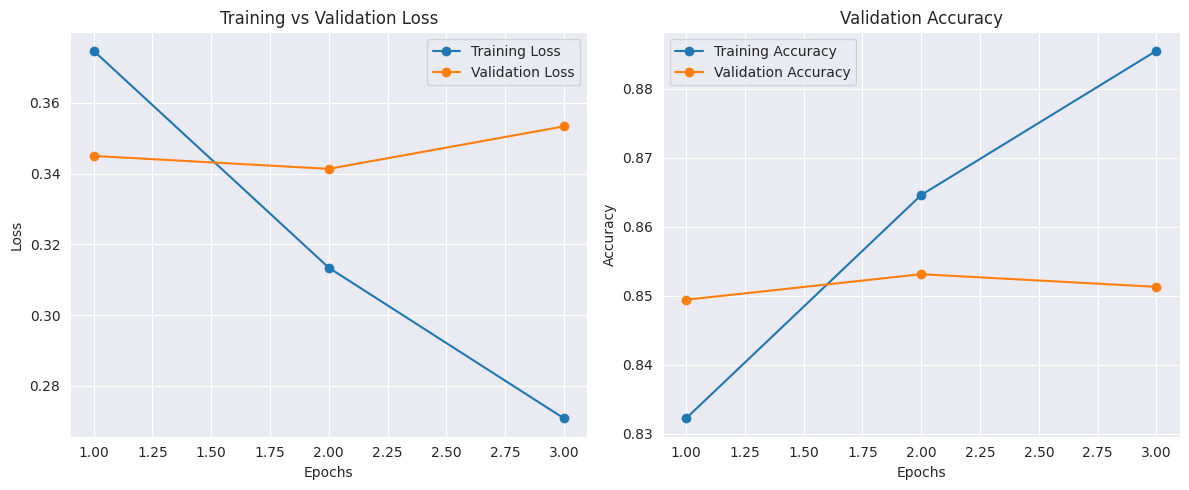

In [27]:
num_epochs = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(num_epochs, train_loss_history, label='Training Loss', marker='o')
plt.plot(num_epochs, val_loss_history, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(num_epochs, train_acc_history, label="Training Accuracy", marker='o')
plt.plot(num_epochs, val_acc_history, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Model

In [47]:
def test_evaluate(model):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(test_dataset, desc="Testing"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    avg_loss = total_loss / len(test_dataset)

    y_true = np.array(true_labels)
    y_pred = np.array(predictions)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    try:
        roc_auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        roc_auc = "Not applicable (non-binary classification)"

    print("\n--- Test Evaluation Metrics ---")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"ROC-AUC: {roc_auc}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [48]:
test_evaluate(bert_model)

Testing: 100%|██████████| 2344/2344 [04:30<00:00,  8.68it/s]



--- Test Evaluation Metrics ---
Loss: 0.3552
Accuracy: 0.8502
Precision (weighted): 0.8504
Recall (weighted): 0.8502
F1 Score (weighted): 0.8501
ROC-AUC: 0.8501568201690328

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     75018
           1       0.86      0.84      0.85     74982

    accuracy                           0.85    150000
   macro avg       0.85      0.85      0.85    150000
weighted avg       0.85      0.85      0.85    150000



### BART

#### Data Pre-Processing

In [21]:
tokenizer = AutoTokenizer.from_pretrained(bart_checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["cleaned_text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_WORDS
    )


def bart_pre_processing():
    BATCH_SIZE = 32

    df = load_data()
    df = df.sample(n=250_000).reset_index(drop=True)

    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["sentiment"])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["sentiment"])
    
    train_dataset = Dataset.from_pandas(train_df[["cleaned_text", "sentiment"]])
    val_dataset = Dataset.from_pandas(val_df[["cleaned_text", "sentiment"]])
    test_dataset = Dataset.from_pandas(test_df[["cleaned_text", "sentiment"]])

    dataset = DatasetDict({
        "train": train_dataset,
        "test": test_dataset,
        "validation": val_dataset
    })

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    tokenized_datasets = tokenized_datasets.rename_column("sentiment", "labels")
    tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=BATCH_SIZE)
    val_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE)

    return (train_dataloader, val_dataloader, test_dataloader)

In [22]:
train_dataloader, val_dataloader, test_dataloader = bart_pre_processing()

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

#### Defining the Model

In [24]:
bart = BartForSequenceClassification.from_pretrained(bart_checkpoint, num_labels=2)
bart.to(device)

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at sshleifer/distilbart-cnn-12-6 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

BartForSequenceClassification(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
   

#### Training the Model

In [33]:
epochs = 3
learning_rate = 2e-5
total_steps = len(train_dataloader) * epochs

optimizer = AdamW(bart.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [27]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train(bart)
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_acc: .4f}")
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    val_loss, val_acc = evaluate(bart)
    print(f"Eval Loss: {val_loss:.4f}")
    print(f"Eval Accuracy: {val_acc:.4f}")
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


Epoch 1/3


Training: 100%|██████████| 6250/6250 [1:46:22<00:00,  1.02s/it]


Train Loss: 0.3331


Evaluating: 100%|██████████| 782/782 [04:19<00:00,  3.02it/s]


Eval Loss: 0.3072
Eval Accuracy: 0.8702

Epoch 2/3


Training: 100%|██████████| 6250/6250 [1:46:18<00:00,  1.02s/it]


Train Loss: 0.2395


Evaluating: 100%|██████████| 782/782 [04:19<00:00,  3.01it/s]


Eval Loss: 0.3166
Eval Accuracy: 0.8755

Epoch 3/3


Training: 100%|██████████| 6250/6250 [1:46:19<00:00,  1.02s/it]


Train Loss: 0.1529


Evaluating: 100%|██████████| 782/782 [04:18<00:00,  3.02it/s]

Eval Loss: 0.3650
Eval Accuracy: 0.8712


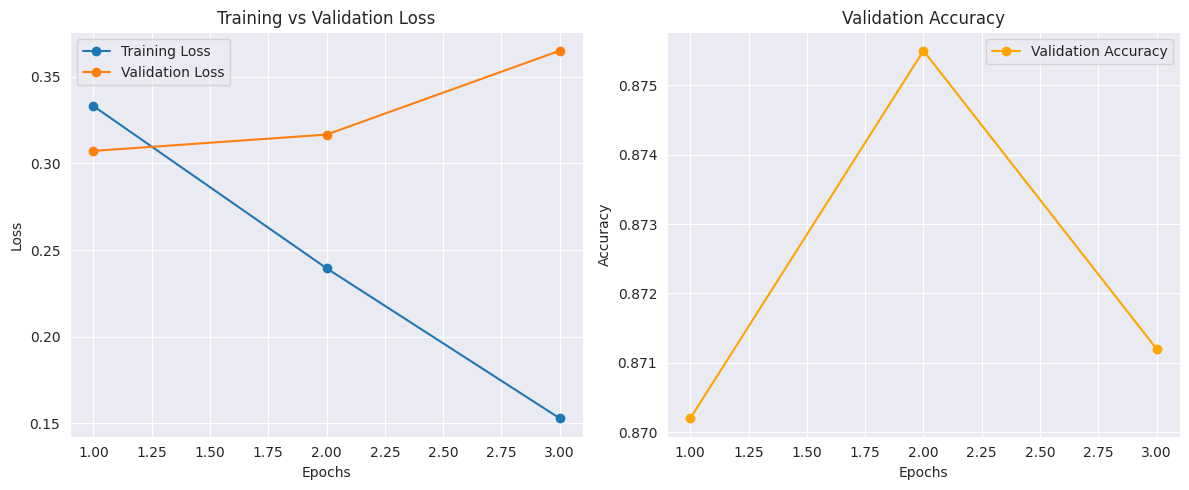

In [35]:
# didnt store the values :)
train_losses = [0.3331, 0.2395, 0.1529]
val_losses = [0.3072, 0.3166, 0.3650]
val_accuracies = [0.8702, 0.8755, 0.8712]
num_epochs = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Training vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(num_epochs, train_losses, label='Training Loss', marker='o')
plt.plot(num_epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Evaluating the Model

In [29]:
test_loss, test_acc = test_evaluate()
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Testing: 100%|██████████| 782/782 [04:17<00:00,  3.04it/s]

Test Loss: 0.3481
Test Accuracy: 0.8780
